**一、LeNet实现**
 

In [ ]:
#model
import torch
import torch.nn as nn
import torch.nn.functional as F
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)#inchanels,outchanels,kernel_size,stride,padding 
        self.pool1 = nn.MaxPool2d(2, 2)#kernel_size,stride
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2=nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model=LeNet()
print(model._modules)#属性，返回的是一个OrderedDict
print(model.modules())#方法，返回的是一个迭代器


print(model.named_modules())#生成器（generator），每个元素是一个 (name, module) 元组。

In [ ]:
#train
import torch
import torchvision
import torch.nn as nn

import torch.optim as optim
import torchvision.transforms as transforms

import torch

torch.cuda.empty_cache()

def main():
    # 定义对数据的预处理
    #先转换为tennsor,将pil或者numpy（h,w，c）转换为（c,h,w）的tensor数据，并将其归一化到（0,1）之间
    transform = transforms.Compose(
        [transforms.ToTensor(),#归一化
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#标准化，前面均值后面方差，对应三个通道

    # 50000张训练图片
    # 第一次使用时要将download设置为True才会自动去下载数据集
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=False, transform=transform)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=36,
                                               shuffle=True, num_workers=0)

    # 10000张验证图片
    # 第一次使用时要将download设置为True才会自动去下载数据集
    val_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=False, transform=transform)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=10000,
                                             shuffle=False, num_workers=0)
    val_data_iter = iter(val_loader)
    val_image, val_label = next(val_data_iter)

    
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    net = LeNet()
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    for epoch in range(10):  # loop over the dataset multiple times
        # net.train()
        running_loss = 0.0
        for step, data in enumerate(train_loader, start=0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs=inputs.to(device)
            labels=labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if step % 500 == 499:    # print every 500 mini-batches
                with torch.no_grad():
                    val_image=val_image.to(device)
                    val_label=val_label.to(device)
                    outputs = net(val_image)  # [batch, 10]
                    predict_y = torch.max(outputs, dim=1)[1]
                    accuracy = torch.eq(predict_y, val_label).sum().item() / val_label.size(0)

                    print('[%d, %5d] train_loss: %.3f  test_accuracy: %.3f' %
                          (epoch + 1, step + 1, running_loss / 500, accuracy))
                    running_loss = 0.0

    print('Finished Training')

    # save_path = './Lenet.pth'
    # torch.save(net.state_dict(), save_path)
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': running_loss,  # 例如保存当前的损失
    }

    # 将 checkpoint 保存到文件
    torch.save(checkpoint, './checkpoint.pth')



if __name__ == '__main__':
    main()

In [ ]:
#predict
checkpoint = torch.load('./checkpoint.pth')
net_dict=checkpoint['model_state_dict']
print(net_dict.keys())
print(checkpoint['loss'])
print(checkpoint['epoch'])
print(checkpoint['optimizer_state_dict'].keys())

import torch
import torchvision.transforms as transforms
from PIL import Image




def main():
    transform = transforms.Compose(
        [transforms.Resize((32, 32)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    net = LeNet()
    net.load_state_dict(net_dict)

    im = Image.open('/home/nizhenhao/桌面/CS182/cs182_hw1_student-main/puppy.jpg')
    
    im = transform(im)  # [C, H, W]
    im = torch.unsqueeze(im, dim=0)  # [N, C, H, W]增加维度，网络的输入是四维的，分别是batch_size，channel，height，width
   
    with torch.no_grad():
        outputs = net(im)
        predict = torch.max(outputs, dim=1)[1].numpy()
    print(classes[int(predict)])


if __name__ == '__main__':
    main()

**二、AlexNet**

In [3]:
import torch.nn as nn
import torch.optim as optim
class AlexNet(nn.Module):
    def __init__(self,num_classes=1000,init_weights=False):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4,padding=2), # 224 --> 55
            nn.ReLU(inplace=True),#表示直接在输入张量上进行操作，节省内存，但可能会覆盖输入数据。False（默认值）：创建一个新的张量存储结果，保留输入张量的原始值。
            nn.MaxPool2d(kernel_size=3, stride=2), # kernel_size, stride  55 --> 27

            nn.Conv2d(96,256,kernel_size=5,stride=1,padding=2), # 27 --> 27
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2), # 27 --> 13

            nn.Conv2d(256,384,kernel_size=3,stride=1,padding=1), # 13 --> 13
            nn.ReLU(inplace=True),
            nn.Conv2d(384,384,kernel_size=3,stride=1,padding=1), # 13 --> 13
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256,kernel_size=3,stride=1,padding=1), # 13 --> 13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3,2), # 13 --> 6

            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
        )
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._intialize_weights()

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)#从第二维开始展平【batch,channels,height,weight】
        x = self.fc(x)
        return x
    def _intialize_weights(self):
        #正常pytorch会初始化好
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)





In [ ]:
#train
import os
import json
import torch.utils
import torch.utils.data
from torchvision import transforms, datasets, utils
from tqdm import tqdm

#确定训练设备
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#数据预处理
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),#随机裁剪
                                    transforms.RandomHorizontalFlip(),#随机水平翻转,数据增强
                                    transforms.ToTensor(),#归一化
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),#标准化
    "val": transforms.Compose([transforms.Resize((224, 224)),  # cannot 224, must (224, 224)
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

#数据集路径
data_root = os.path.abspath(os.path.join(os.getcwd()))  # get data root path
print(data_root)
image_path = os.path.join(data_root, "dataset", "flower_data")  # flower data set path
print(image_path)
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
#使用torchvison的datasets.ImageFolder来构建数据集，也可以使用torch.utils.data.Dataset来构建数据集，但是ImageFolder更加方便。torch.utils.data.Dataset需要自己写数据集的读取和预处理，而ImageFolder已经封装好了这些操作。
#只适合分类任务，不适合目标检测任务

#构建数据集
train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                        transform=data_transform["train"])

train_num = len(train_dataset)
#构建label_dict字典，将label转换为数字
flower_list = train_dataset.class_to_idx

cla_dict = dict((val, key) for key, val in flower_list.items())
print(cla_dict)
json_str = json.dumps(cla_dict, indent=4)# 将 Python 字典对象转换为 JSON 格式的字符串,indent=4表示缩进4个空格
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)
#构建dataloder
batch_size = 32
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
train_dataloder=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=nw)
# print(len(train_dataloder))#返回的是批次总数

validation_dateset=datasets.ImageFolder(root=os.path.join(image_path,"val"),transform=data_transform["val"])
val_num=len(validation_dateset)
val_dataloader=torch.utils.data.DataLoader(validation_dateset,batch_size=batch_size,shuffle=False,num_workers=nw)
print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))

#训练代码框架
epochs=10
save_path='./AlexNet.pth'

#实例化网络，损失函数，优化器
net=AlexNet(num_classes=5,init_weights=True)
net.to(device)
loss_function=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=0.0002)
best_acc=0.0
train_steps=len(train_dataloder)#返回一个epoch中包含的batch数量
for epoch in range(epochs):
    #训练
    net.train()#可以确保dropout,BN等层在训练时正常工作,这些层在训练和测试时的行为是不同的
    running_loss=0.0
    train_bar = tqdm(train_dataloder)#这里将 train_loader 作为输入，包装成一个带有进度条的可迭代对象。
    for step,data in enumerate(train_bar,start=0):#使用的是train_bar,而不是train_dataloder，因为train_bar是一个带有进度条的可迭代对象，它可以在训练过程中显示训练进度。
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        outputs=net(images)
        
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)
    #训练一轮，然后使用验证集进行验证
    net.eval()#将模型设置为评估模式，这通常用于在测试或验证数据上评估模型性能。
    acc=0.0
    with torch.no_grad():
        val_bar=tqdm(val_dataloader)
        for val_data in val_bar:
            val_images,val_labels=val_data
            outputs=net(val_images.to(device))#输出大小为(batch_size, num_classes)
            predict_y=torch.max(outputs,dim=1)[1]#获取预测结果中最大值的索引，即预测的类别标签
            #torch.eq 比较预测值和真实值的每个元素是否相等，返回布尔张量。
            #.sum() 统计布尔张量中 True 的数量，即预测正确的样本数。
            #.item() 将该数量转化为 Python 整型值，便于后续处理。
            acc+=torch.eq(predict_y,val_labels.to(device)).sum().item()#计算预测正确的样本数量

    val_accurate=acc/val_num#计算准确率
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %(epoch+1,running_loss/train_steps,val_accurate))
    if val_accurate>best_acc:
        best_acc=val_accurate
        torch.save(net.state_dict(),save_path)
            





In [ ]:
#predict
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt




def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # load image
    img_path = "/home/nizhenhao/桌面/CS182/the learn of torch and model/dataset/flower_data/flower_photos/roses/19153732586_9de58c8f53_n.jpg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)


    plt.imshow(img)

    # [N, C, H, W]
    img = data_transform(img)
    print(img.shape)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)

    # read class_indict
    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    with open(json_path, "r") as f:
        class_indict = json.load(f)
    print(class_indict)

    # create model
    model = AlexNet(num_classes=5).to(device)

    # load model weights
    weights_path = "./AlexNet.pth"
    assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
    model.load_state_dict(torch.load(weights_path))

    model.eval()
    with torch.no_grad():
        # predict class
        a=model(img.to(device))
        
        output = torch.squeeze(model(img.to(device))).cpu()#squeeze()函数的功能是从矩阵shape中，去掉维度为1的。这里的输出之前为（1，5），输出之后为（5，）
        
        predict = torch.softmax(output, dim=0)
        # print(predict)
        predict_cla = torch.argmax(predict).numpy()
        # print(predict_cla)

    print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
    plt.title(print_res)
    for i in range(len(predict)):
        print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                  predict[i].numpy()))
    plt.show()


if __name__ == '__main__':
    main()

**三、VGGNet实现**

**亮点**  

1.提出了比AlexNet更深的网络结构，并验证了增加网络的深度能够在一定程度上影响网络最终的性能。 

2.提出可以通过使用多个小的3×3卷积核替换大的5×5卷积核，从而减少参数并提高效率。


In [5]:
import torch
import torch.nn as nn
class VGGNet(nn.Module):
    def __init__(self, num_classes=1000,init_weights=False):
        super(VGGNet, self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,32,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),#224/2=112

            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),#112/2=56

            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),#56/2=28

            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),#28/2=14

            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),#14/2=7
        )
        self.classifier=nn.Sequential(
            nn.Linear(256*7*7,1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024,1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024,num_classes)
        )
        if init_weights:
            self._initialize_weights()

    def forward(self,x):
        x=self.features(x)
        x=torch.flatten(x,start_dim=1)
        x=self.classifier(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                # nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

      

In [ ]:
#train
from torchvision import datasets, transforms
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
#处理数据
import torch
torch.cuda.empty_cache()  # 手动清理显存

transform={"train":transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
]),
"val":transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])}

#构建数据集及数据加载器
train_dataset=datasets.ImageFolder(root="/home/nizhenhao/桌面/CS182/the learn of torch and model/dataset/flower_data/train",transform=transform["train"])
val_dataset=datasets.ImageFolder(root="/home/nizhenhao/桌面/CS182/the learn of torch and model/dataset/flower_data/val",transform=transform["val"])
batch_size=32
num_workers=8
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)
val_loader=torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

#实例化模型，定义损失函数和优化器，确定训练设备
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model=VGGNet(num_classes=5,init_weights=True)
model.to(device)
loss_function=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.0001)
#训练
train_steps=len(train_loader)
for epoch in range(30):
    model.train()
    running_loss=0.0
    train_bar=tqdm(train_loader)
    for step,data in enumerate(train_bar):
        images,labels=data
        optimizer.zero_grad()
        outputs=model(images.to(device))
        loss=loss_function(outputs,labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        train_bar.desc="train epoch[{}/{}] loss:{:.3f}".format(epoch+1,30,loss)
    model.eval()
    acc=0.0
    with torch.no_grad():
        val_bar=tqdm(val_loader)
        for val_data in val_bar:
            val_images,val_labels=val_data
            outputs=model(val_images.to(device))
            predict_y=torch.max(outputs,dim=1)[1]
            acc+=torch.eq(predict_y,val_labels.to(device)).sum().item()
    val_accurate=acc/len(val_dataset)
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %(epoch + 1, running_loss / train_steps, val_accurate))
print('Finished Training')


**四、GoogLeNet**  

**亮点**  
1、引入Inception模块，将卷积层和池化层并行化，同时使用1x1卷积核进行降维，减少计算量  
2、丢弃全连接层，使用全局平均池化层，减少参数量  
3、使用辅助分类器，缓解梯度消失问题  


**1、Inception模块**  
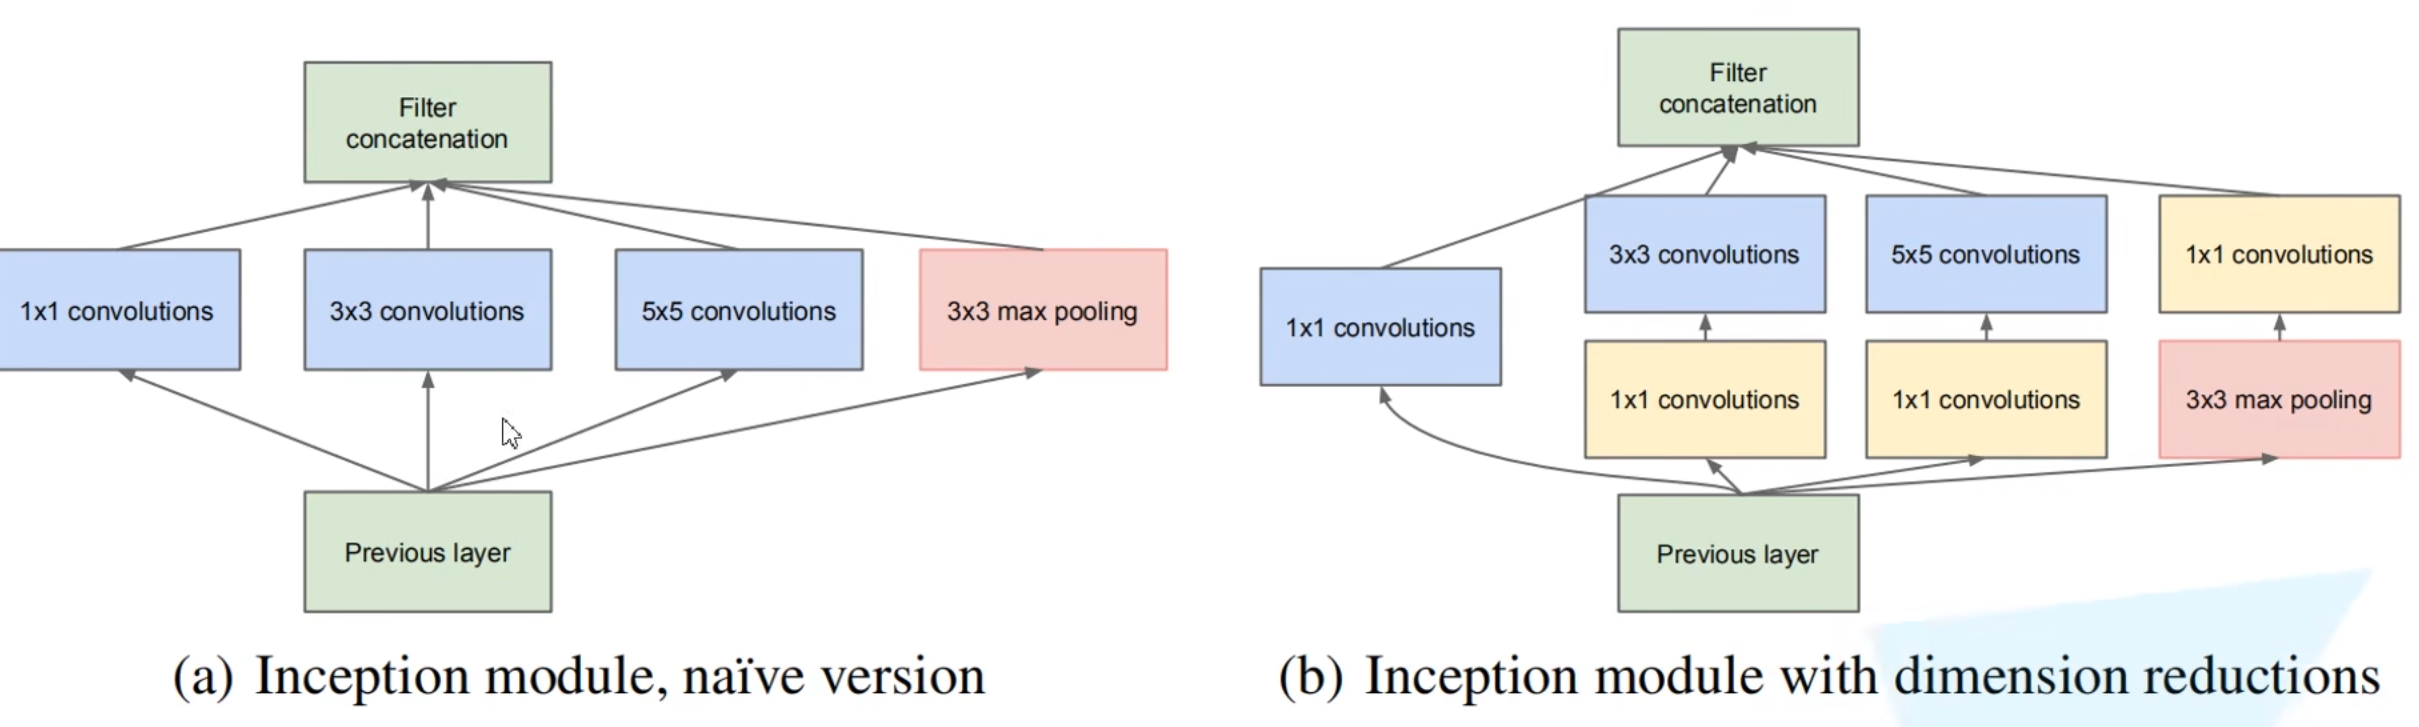
**对于（a），对于输入并行处理，每个分支所得的特征矩阵高和宽必须相同，才能使每个分支输出的特征矩阵能够直接拼接。在通道层面上拼接，拼接后的特征矩阵的通道数是每个分支输出特征矩阵通道数的总和。  
对于（b），使用1x1卷积核，将输入特征矩阵的通道数减少，再进行并行处理。**

**2、辅助分类器**
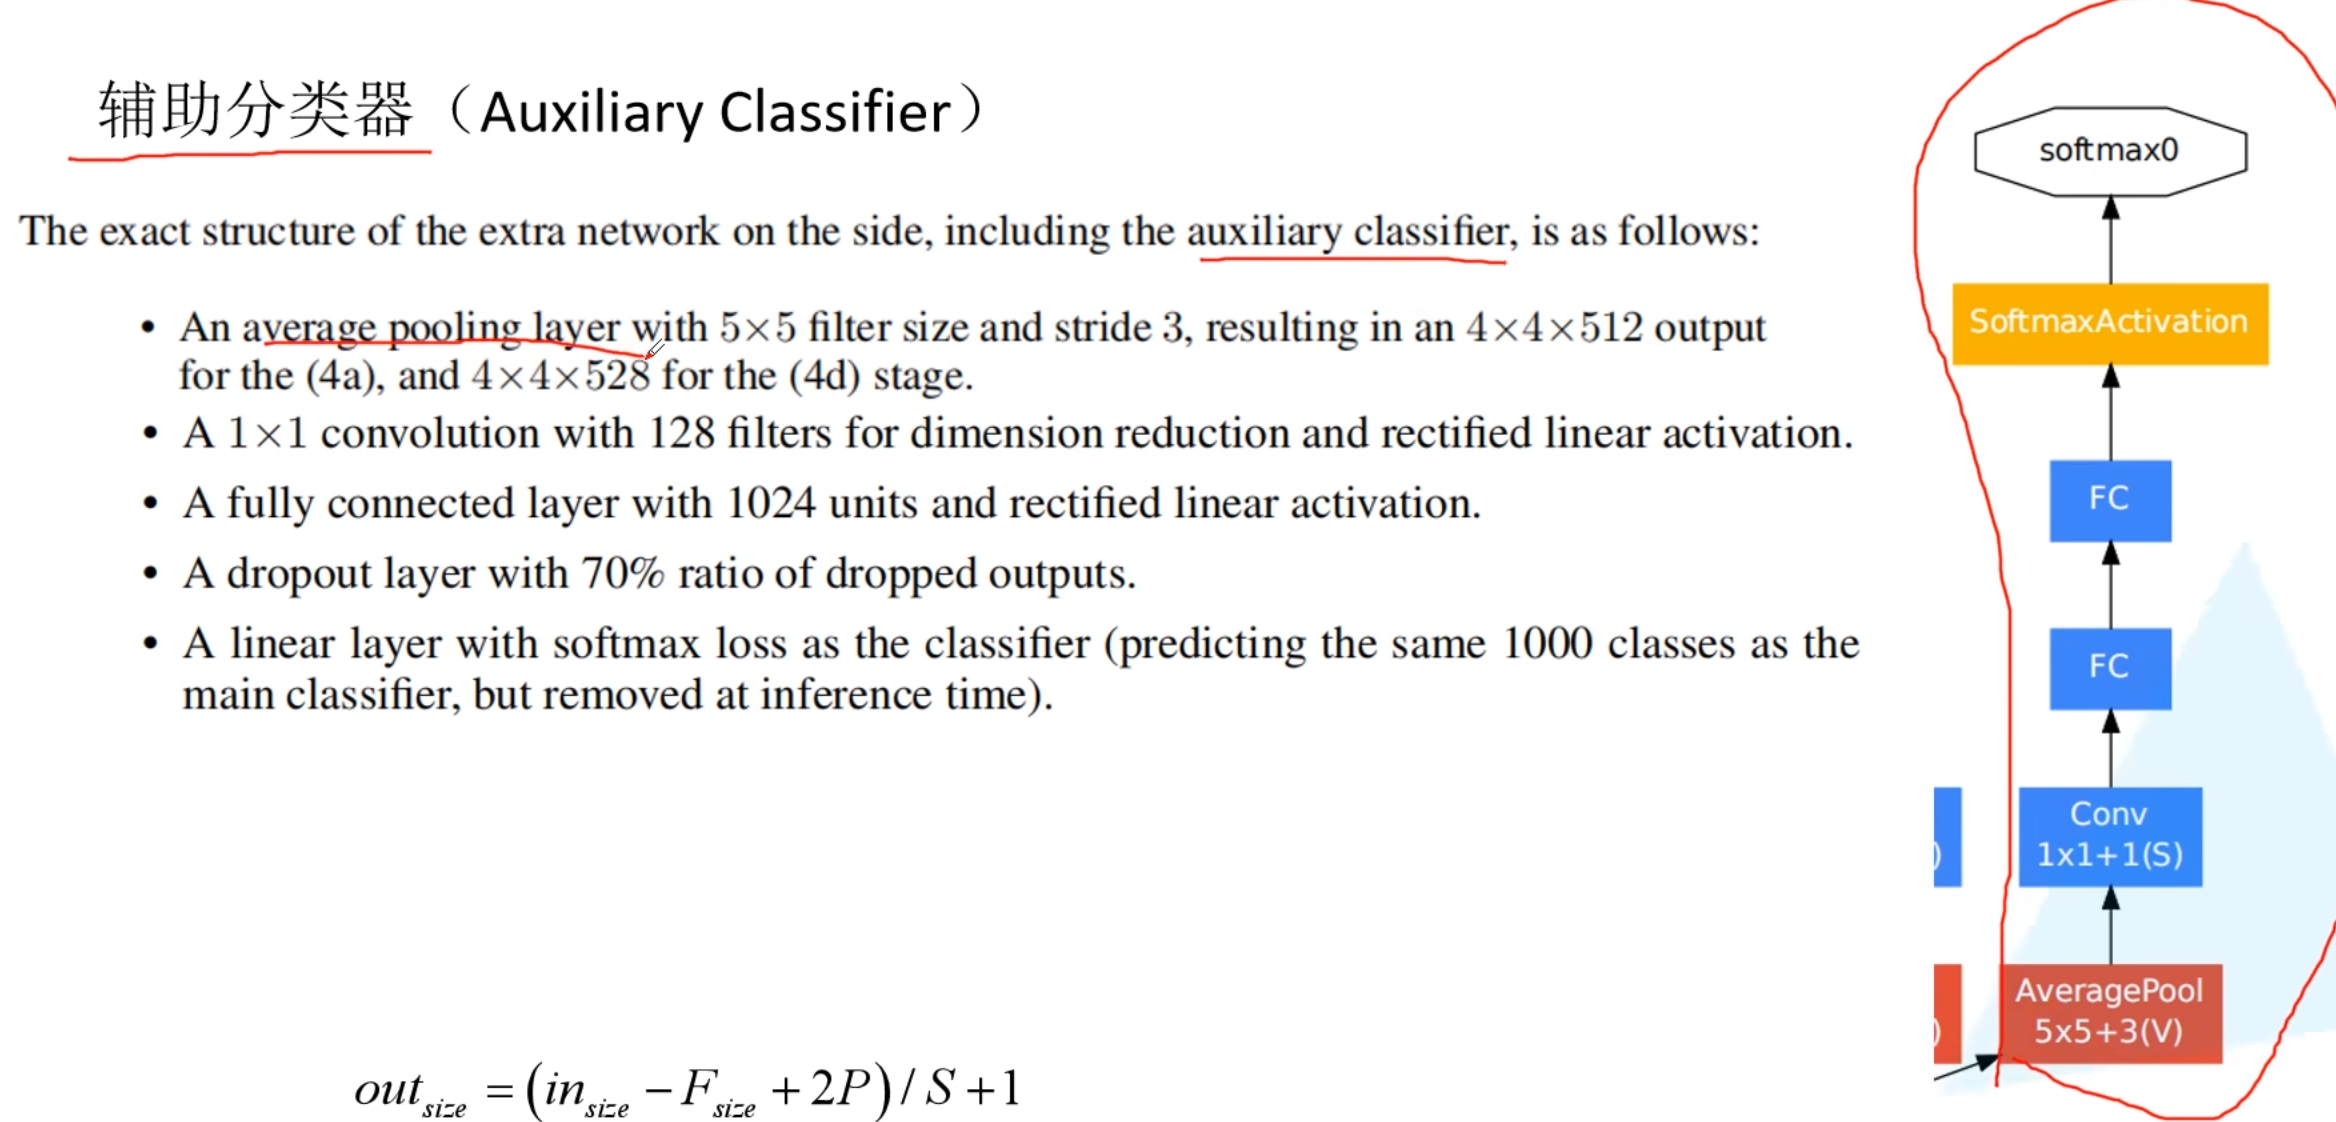  


**3、全局平均池化层**   
所谓的全局是针对常用的 Average Pooling 而言，Average Pooling 会有它的 filter_size，比如 2 x 2，全局平均池化就没有size，它针对的是整张 feature map。GAP将 feature map 所有像素值相加求平均，得到一个数值，即用该数值表示对应 feature map。  

目的：替代全连接层

效果：减少参数数量，减少计算量，减少过拟合  

输入[batch_size,channel,height,width] 输出[batch_size,channel,1,1]

In [2]:
#model
import torch.nn as nn
import torch
import torch.nn.functional as F





class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True, init_weights=False):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)#224-->112 计算得出112.5,向下取整，
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)#ceil_mode=True意味着向上取整， 112-->56

        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)#大小不变 56-->56
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)#56-->28

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)#输入192通道，1输出256通道，大小不变 28-->28
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)#28-->14

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)#14-->7

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))#自适应平均池化，输出大小为1*1
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        if self.training and self.aux_logits:    # eval model lose this layer
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        if self.training and self.aux_logits:    # eval model lose this layer
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7
        
        #不通过直接展平，而是通过平均池化，再展平，可以减少参数量
        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
        if self.training and self.aux_logits:   # eval model lose this layer
            return x, aux2, aux1
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

#inception_block
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)#1x1卷积层加relu激活层

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),#1x1卷积层加relu激活层
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)   # 3x3卷积层加relu，保证输出大小等于输入大小
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),#1x1卷积层加加relu激活层
         
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)   # 保证输出大小等于输入大小
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)#在通道维度上拼接， [] 表示这是一个列表，其中包含需要拼接的张量（如 tensor1、tensor2、tensor3）。

#辅助分类器模块
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)  # output[batch, 128, 4, 4]

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.averagePool(x)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)#在model.train()时，self.training为True，dropout会正常工作。
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        return x

#实现一个卷积块，包括卷积层，激活层
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x

In [ ]:
#train
from torchvision import datasets, transforms
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
#处理数据
import torch
torch.cuda.empty_cache()  # 手动清理显存

transform={"train":transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
]),
"val":transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])}

#构建数据集及数据加载器
train_dataset=datasets.ImageFolder(root="/home/nizhenhao/桌面/CS182/the learn of torch and model/dataset/flower_data/train",transform=transform["train"])
val_dataset=datasets.ImageFolder(root="/home/nizhenhao/桌面/CS182/the learn of torch and model/dataset/flower_data/val",transform=transform["val"])
batch_size=32
num_workers=8
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)
val_loader=torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

#实例化模型，定义损失函数和优化器，确定训练设备
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model=GoogLeNet(num_classes=5,aux_logits=True,init_weights=True)
model.to(device)
loss_function=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.0001)
#训练
train_steps=len(train_loader)
for epoch in range(30):
    model.train()
    running_loss=0.0
    train_bar=tqdm(train_loader)
    for step,data in enumerate(train_bar):
        images,labels=data
        optimizer.zero_grad()
        outputs,aux_logits1,aux_logits2=model(images.to(device))#网络输出有3个，分别是主输出，辅助分类器输出1，辅助分类器输出2

        loss0=loss_function(outputs,labels.to(device))
        loss1=loss_function(aux_logits1,labels.to(device))
        loss2=loss_function(aux_logits2,labels.to(device))
        loss=loss0+(loss1+loss2)*0.3#原论文中设置的权重

        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        train_bar.desc="train epoch[{}/{}] loss:{:.3f}".format(epoch+1,30,loss)
    model.eval()#辅助分类器不参与评估，最后只有一个输出
    acc=0.0
    with torch.no_grad():
        val_bar=tqdm(val_loader)
        for val_data in val_bar:
            val_images,val_labels=val_data
            outputs=model(val_images.to(device))
            predict_y=torch.max(outputs,dim=1)[1]
            acc+=torch.eq(predict_y,val_labels.to(device)).sum().item()
    val_accurate=acc/len(val_dataset)
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %(epoch + 1, running_loss / train_steps, val_accurate))
print('Finished Training')


**五、ResNet!!!**  
Resnet在cnn图像方面有着非常突出的表现，它利用 shortcut 短路连接，解决了深度网络中模型退化的问题。相比普通网络每两层/三层之间增加了短路机制，通过残差学习使深层的网络发挥出作用。  

**亮点**  
1.超深的网络结构（超过1000层）。  
2.提出residual（残差结构）模块。  
3.使用Batch Normalization加速训练（丢弃dropout）。  

**深度学习的退化现象**  
在深度学习中，退化现象主要指的是随着神经网络层数的增加，网络性能反而下降的情况。这种现象与人们的直觉相悖，因为通常认为更深的网络能够学习到更复杂的特征表示，从而提高模型的性能。然而，在实际应用中，过深的网络往往会导致梯度消失、梯度爆炸、过拟合以及低级特征丢失等问题，进而引发性能退化。  

**深度学习退化现象的原因**  
1、梯度问题：随着网络层数的增加，梯度在反向传播过程中可能会逐渐变小（梯度消失）或变大（梯度爆炸），导致网络无法进行有效的参数更新，从而影响模型的性能。  
2、过拟合：深度网络具有强大的表达能力，容易在训练数据上过度拟合，导致在测试集上的性能下降。  
3、低级特征丢失：过深的网络可能过于关注高级特征的学习和表达，而忽略了低级特征的重要性，从而丧失了一些有效的特征表示能力。  

**深度学习退化现象的解决方案**  
为了解决深度学习中的退化现象，研究者们提出了多种解决方案，其中最具代表性的是残差网络（ResNet）及其恒等映射机制。  

1、残差网络（ResNet）：ResNet通过引入残差结构和恒等映射，使得网络在加深时能够保持或提升性能。残差块中的恒等映射允许输入直接传递到输出，与经过卷积层处理的特征相加，从而缓解了梯度消失和梯度爆炸问题，并有助于保留低级特征。  
2、参数初始化和归一化：合适的参数初始化和归一化方法可以改善模型的稳定性和收敛速度。例如，使用符合高斯分布的初始化方法，并结合批量归一化技术（Batch Normalization），可以使得网络的训练更加稳定，减少退化问题的发生。  
3、网络架构设计：通过设计更深层次的网络架构，引入更多的非线性变换和特征交互，可以提升模型的表达能力和准确率。然而，这也需要谨慎控制网络的复杂度，以避免过拟合和计算成本的增加。  
4、数据增强和正则化：数据增强和正则化技术可以帮助防止过拟合的发生，提高模型的泛化能力。对于退化问题，适当的数据增强和正则化方法可以减少模型对训练数据的过度依赖，提高性能和鲁棒性。  



**残差学习**  
残差学习是指在网络中通过引入残差块（Residual Block），使得网络能够学习输入与输出之间的残差，而不是直接学习完整的输出。残差块通过跳跃连接（Skip Connection）将输入直接连接到输出，与经过网络处理的特征相加，形成残差学习的基本结构。  

**效果**   
1、解决梯度消失和梯度爆炸： 
传统深度神经网络在训练过程中，随着层数的增加，梯度在反向传播过程中可能会逐渐减小（梯度消失）或增大（梯度爆炸），导致网络难以训练。
残差学习通过引入跳跃连接，使得梯度可以直接从深层传递到浅层，避免了梯度在传递过程中的损失和爆炸，从而解决了梯度消失和梯度爆炸问题。  
2、提高网络性能：  
残差网络通过堆叠多个残差块来构建深层网络，每个残差块都能学习到输入与输出之间的残差，这种学习方式有助于网络更好地捕捉数据中的特征信息。
残差学习使得网络在加深时能够保持或提升性能，避免了传统深度神经网络在加深时出现的性能退化现象。  

**残差学习与残差块**  
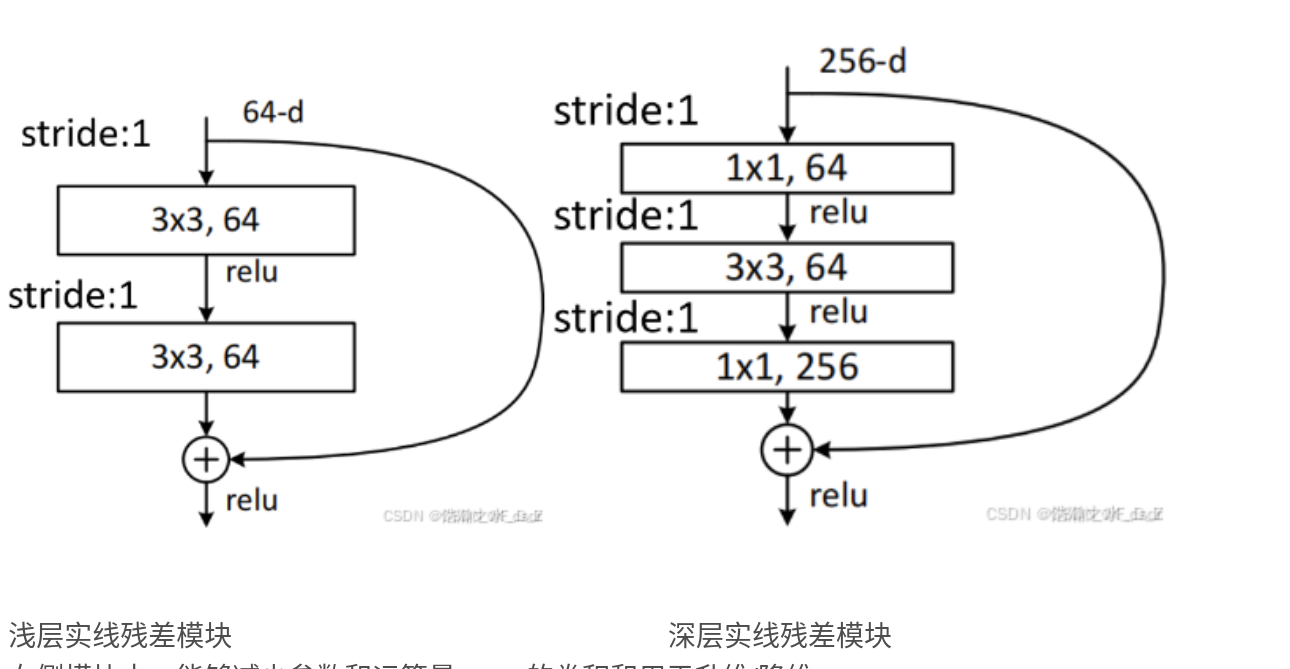

**实线残差块不需其他操作，虚线残差块需要额外操作，如卷积层，池化层等。**  
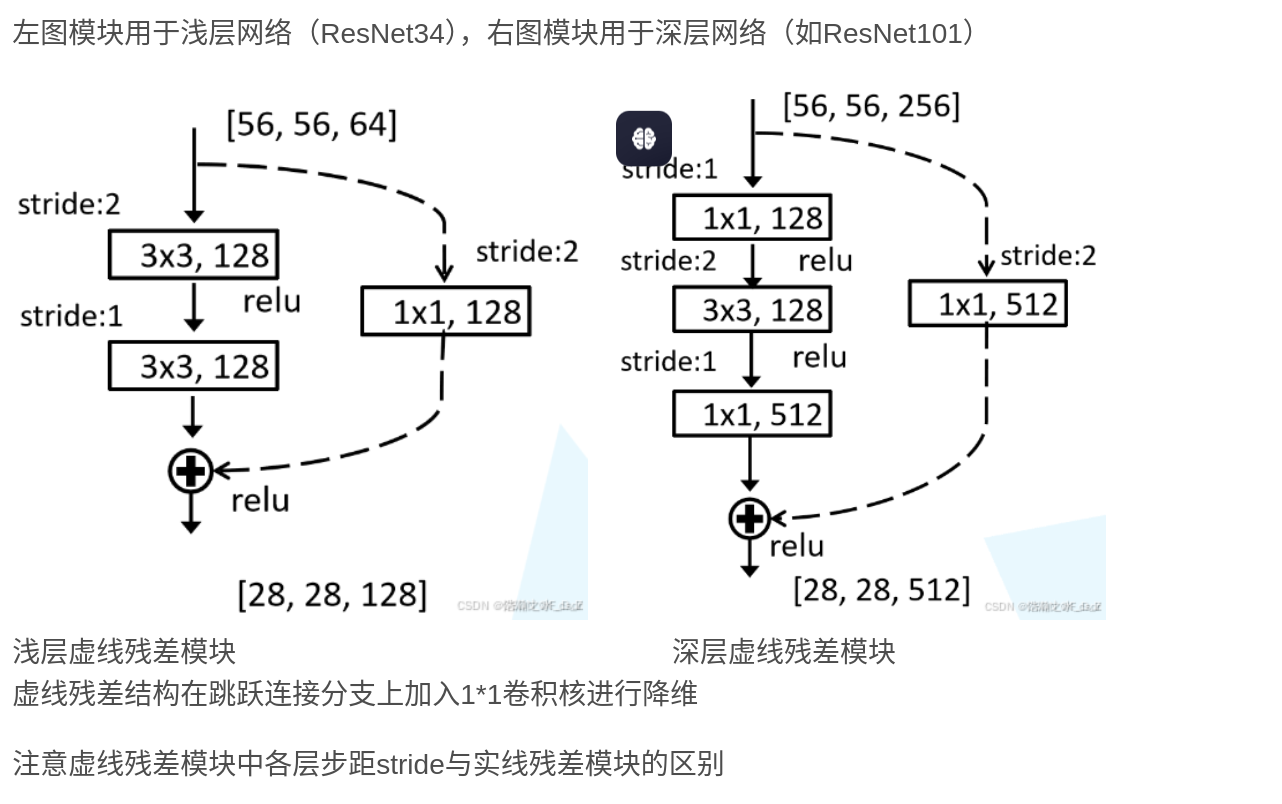




**resnet究竟在解决一个什么问题？** 
--- 
过拟合？  
---
过拟合的特征应该是训练误差小，测试误差大。  
而网络越深，训练误差大，测试误差也大。
---
梯度消失？梯度爆炸？
---
梯度消失的特征是，随着网络层数的增加，梯度会越来越小，导致参数更新缓慢，训练速度变慢。
但batch_normalization可以很大解决这个问题。

Maybe  
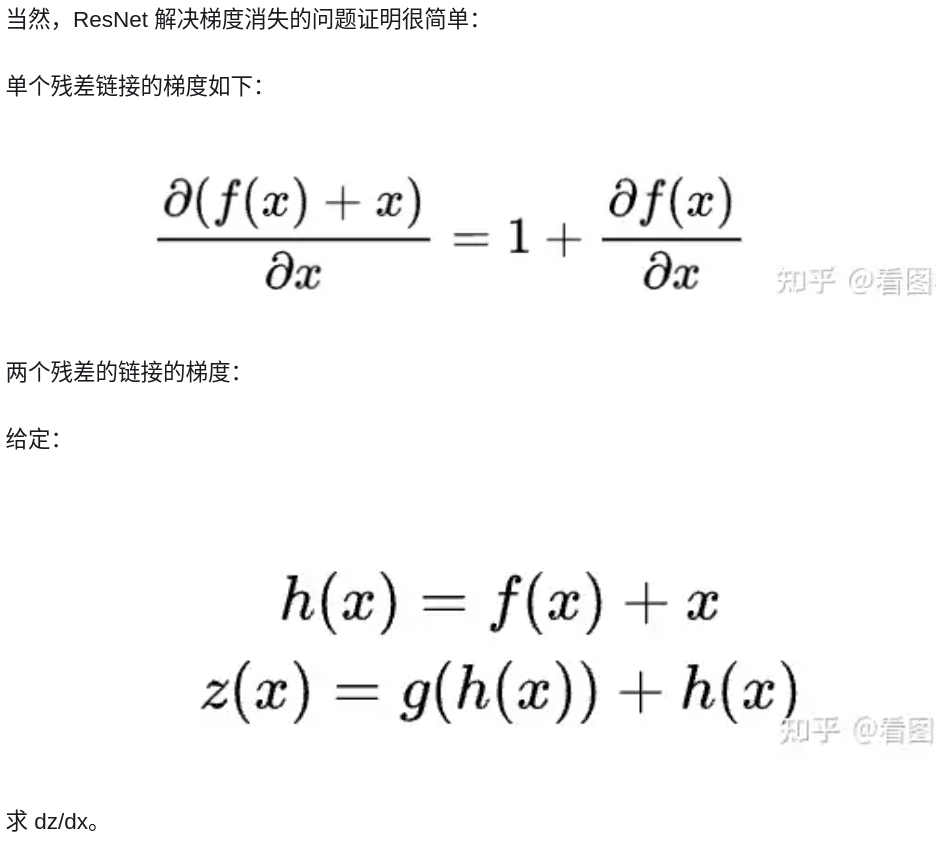
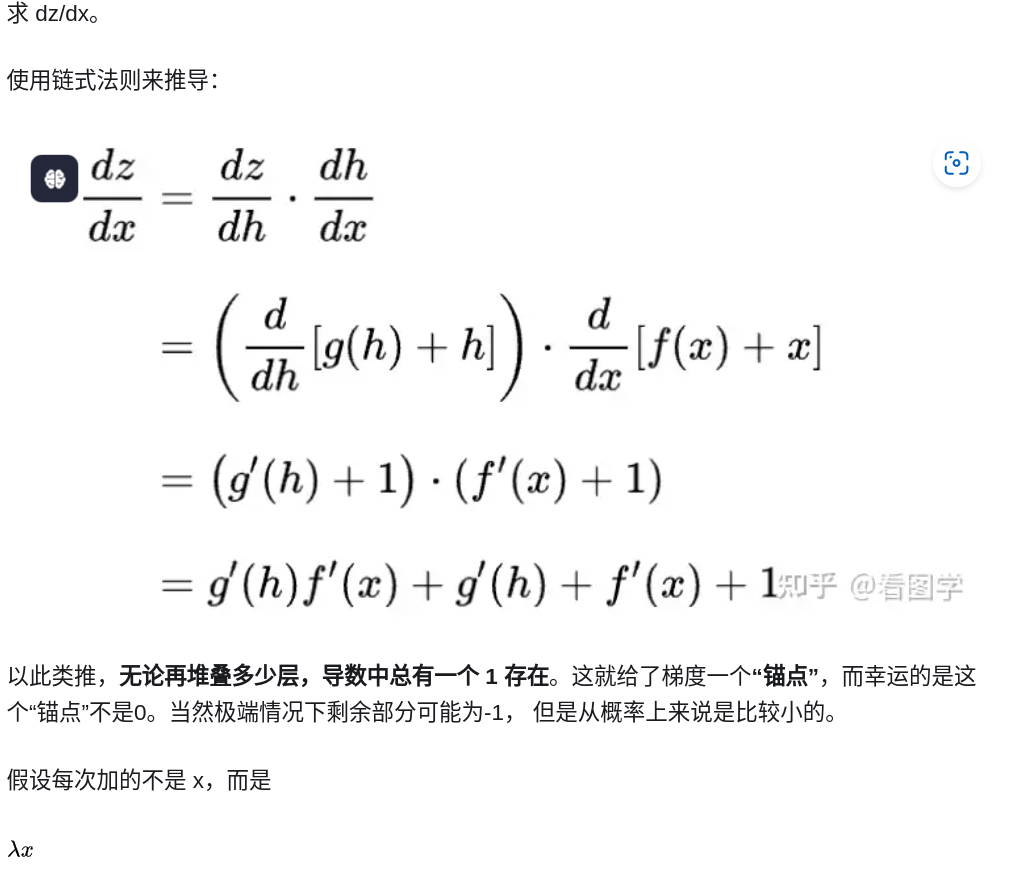
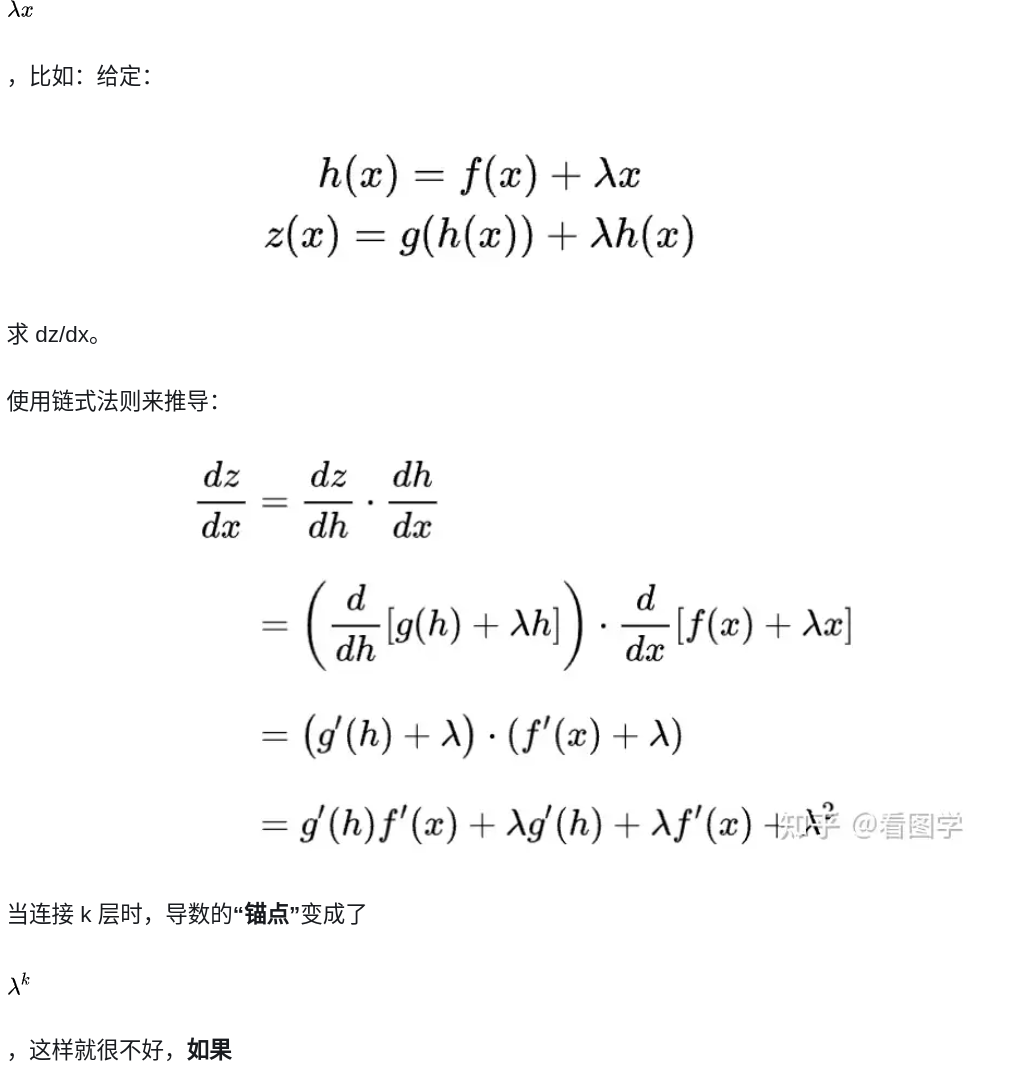
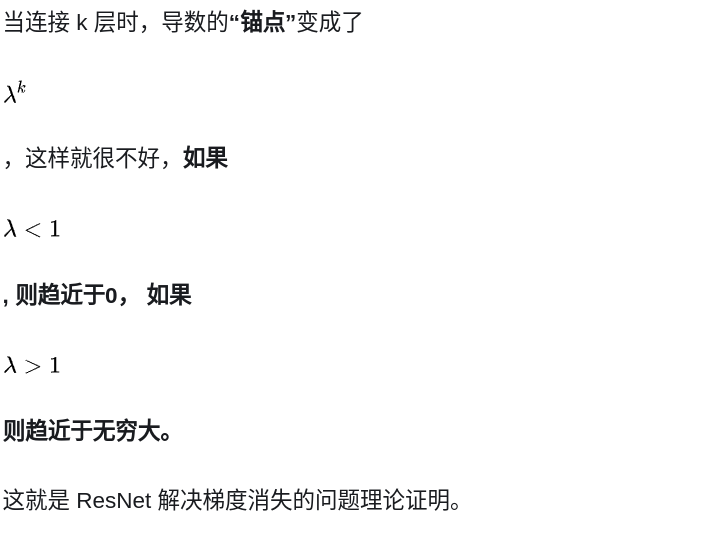
---
Maybe是赋予神经网络无限可能性的“非线性”让神经网络走得太远，越也让它忘记了为什么出发。让其不忘初心的方法叫做“恒等映射” 
 
---
**网络越深，不应该比网络越浅更差。**

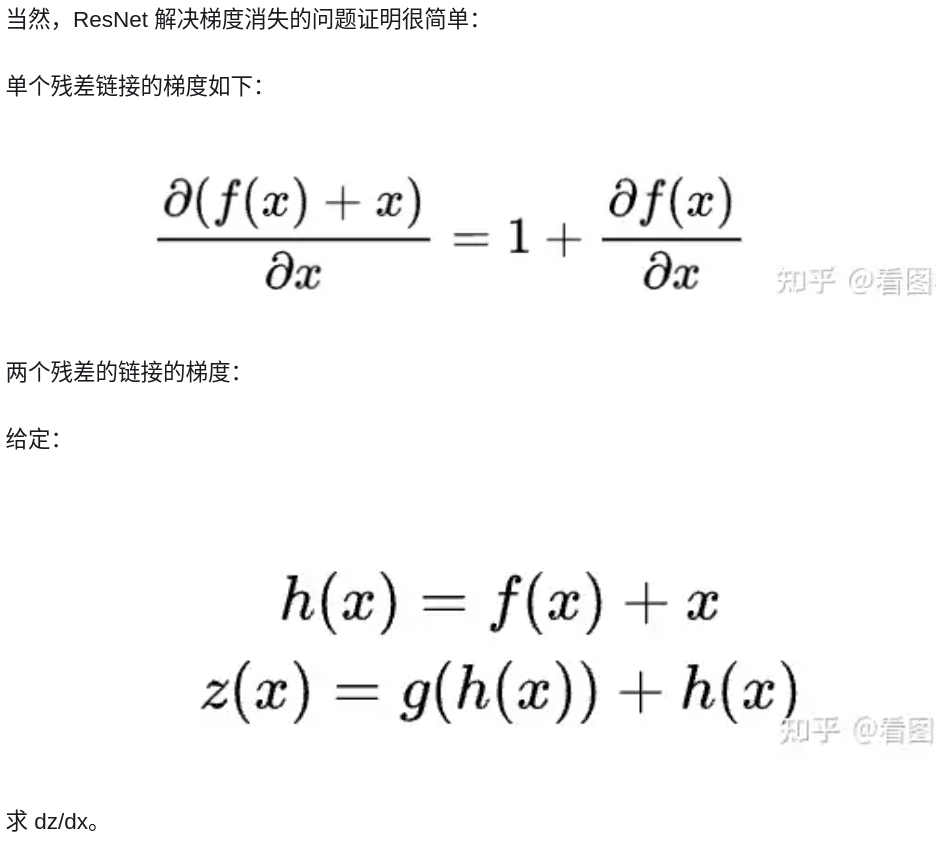  
**右侧网络中 G(x) 如果能很好的拟合 identity 函数(输入等于输出)的话，效果至少可以和左侧浅层网络持平，不应该变差。但事实就是更深的网络效果更差了，所以何恺明推测 G(x) 这样的非线性函数并不能很好的拟合 identity 函数，解决的方法就是想办法把 identity 函数加入到网络中，这样效果最起码能追平浅层的网络，而且更多的参数理应效果更好才是合理的。**





**resnet结构**
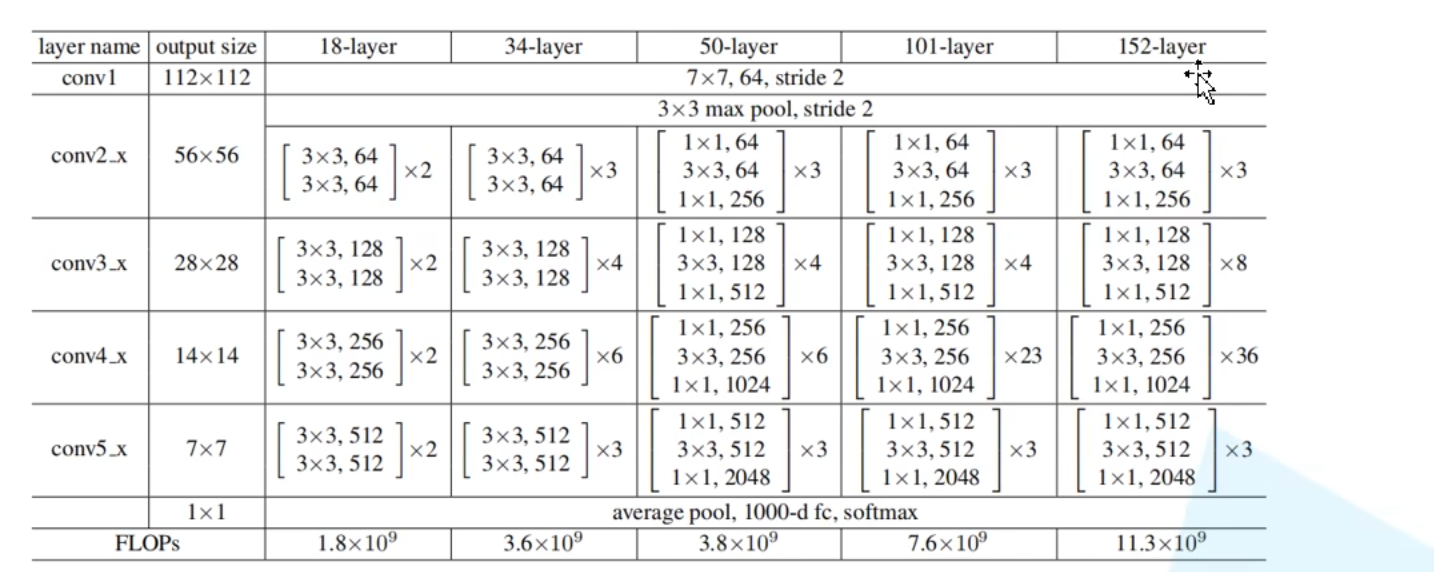

**对于resnet18,34层，残差快的中卷积核的数量没有发生改变，但其他的有改变的**  
**无论多少层resnet,都有虚线形式的残差快，因为需要改变feature——map的大小**

In [10]:
#model
import torch
import torch.nn as nn
import torch.nn.functional as F


#对于resnet18，34的基础残差结构块
class BasicBlock(nn.Module):
    expansion=1#残差结构中卷积核个数是否发生变化
    def __init__(self, in_channels, out_channels, stride=1,downsample=None):
        #downsample用于控制残差结构中卷积核个数是否发生变化，默认是None，不变化.即既要实现实线残差结构，又要实现虚线残差结构
        #stride=1,则是实线残差结构，stride=2，则是虚线残差结构。stride=2时，output_size=input_size/2+0.5,最后向下取整。（在conv中都是向下取整，而在pooling层中，可以控制ceil_mode=True,向上取整）
        super(BasicBlock, self).__init__()

        self.conv1=nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)#如果同时使用卷积层的 bias 和 BN 的平移参数 β，两者的作用会重叠，导致参数的冗余。
        self.bn1=nn.BatchNorm2d(out_channels)#对每个通道进行标准化，例如输入为【batch_size,channels,height,width】，则对每个通道，均值是N*H*W来计算的
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2=nn.BatchNorm2d(out_channels)
        self.downsample=downsample
    def forward(self, x):
        identity=x
        if self.downsample is not None:#虚线残差结构。downsample自定义
            identity=self.downsample(x)
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)
        out=self.conv2(out)
        out=self.bn2(out)
        out+=identity
        out=self.relu(out)
        return out



        

In [11]:

#对于resnet 50,101等更高层的基础残差结构块
class Bottleneck(nn.Module):
    expansion = 4#第三个卷积核的通道数是第一个卷积核的通道数的4倍
    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,kernel_size=1,stride=1,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu=nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel*self.expansion,kernel_size=1,stride=1,bias=False)
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += identity
        out = self.relu(out)
        return out



                               

In [13]:
#resnet
class ResNet(nn.Module):
    def __init__(self,block,block_num,num_classes=1000):
        """
        param block:根据resnet层数，选择basicblock还是bottleneckblock
        param block_num:列表，列表中每个元素代表block中basicblock的个数
        param num_classes:最后的分类类别数
        """
        super(ResNet, self).__init__()
        
        #输入通道数，图像已经经过一个卷积和池化层
        self.inchannel = 64

        self.conv1 = nn.Conv2d(3,self.inchannel,kernel_size=7, stride=2, padding=3, bias=False)#224 --> 112
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)#112 --> 56

        #resnet34
        self.layer1 = self._make_layer(block, 64, block_num[0])#56 --> 56 第一个卷积层的通道数为64，对于resnet 50，101，152，第一个卷积层的通道数为64,但第3个卷积层的通道数为256
        self.layer2=self._make_layer(block, 128, block_num[1], stride=2)#56 --> 28，第一个卷积层的通道数为128
        self.layer3=self._make_layer(block, 256, block_num[2], stride=2)#28 --> 14，第一个卷积层的通道数为256
        self.layer4=self._make_layer(block, 512, block_num[3], stride=2)#14 --> 7，第一个卷积层的通道数为512

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))#自适应平均池化，输出为1*1
        self.fn=nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)



    def _make_layer(self, block, channel, block_num, stride=1):
        """
        param block:block的类型
        param channel:block的第一层的输入通道数
        param block_num:block的个数，例如resnet34的layer2有3个block，layer3有4个block
        param stride:block的步长
        """
        downsample = None
        if stride != 1 or self.inchannel != channel * block.expansion:#前面对于18，34，后面判断对于50，101，152
            downsample = nn.Sequential(
                nn.Conv2d(self.inchannel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))#不需要relu,因为后面有relu，它是加入到输出上，output=relu(input+downsample)
        layers = []
        for i in range(block_num):
            if i == 0:
                layers.append(block(self.inchannel, channel, stride, downsample))#只有第一个block可能要下采样，它的输入通道数和输出通道数可能不一样
                self.inchannel = channel * block.expansion#更新通道数,在同一layer中，只有第一层可能需要虚线残差结构，其他都是实线残差结构
            else:
                layers.append(block(self.inchannel, channel))#都是实线残差结构

        
        return nn.Sequential(*layers)#*layers 将一个列表或元组中的元素解包并传递给 nn.Sequential，可以方便地构造具有多个层的神经网络子结构。


    def forward(self, x):
        x = self.conv1(x)#224 --> 112,3-->64
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)#112 --> 56,64-->64

        x=self.layer1(x)#56 --> 56,64-->64
        x=self.layer2(x)#56 --> 28,128-->128
        x=self.layer3(x)#28 --> 14,256-->256
        x=self.layer4(x)#14 --> 7,512-->512

        x = self.avgpool(x)#batch_size*512*1*1
        x = torch.flatten(x, 1)#展平,batch_size*512
        x = self.fn(x)#batch_size*num_classes
        return x


        

                     

            




In [ ]:
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3],num_classes=5)
print(resnet34)

In [ ]:
#train
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#use resnet34
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3],num_classes=5)
resnet34.to(device)

transform={"train":transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
"val":transforms.Compose([
    transforms.Resize(256),#将短边缩放至256，长宽比不变
    transforms.CenterCrop(224),#从中心裁剪224*224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])}

train_datdaset=datasets.ImageFolder(root='/home/nizhenhao/桌面/CS182/the learn of torch and model/dataset/flower_data/train',transform=transform['train'])
val_datdaset=datasets.ImageFolder(root='/home/nizhenhao/桌面/CS182/the learn of torch and model/dataset/flower_data/val',transform=transform['val'])

batch_size=32
train_dataloder=DataLoader(train_datdaset,batch_size=32,shuffle=True,num_workers=8)
val_dataloder=DataLoader(val_datdaset,batch_size=32,shuffle=True,num_workers=8)

#定义损失，优化器
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(resnet34.parameters(),lr=0.001)

train_steps=len(train_dataloder)#用来计算损失
#训练

epochs=30
for epoch in range(epochs):
    train_loss=0
    train_bar=tqdm(train_dataloder)
    resnet34.train()
    for steps,data in enumerate(train_bar):
        images,labels=data
        optimizer.zero_grad()
        outputs=resnet34(images.to(device))
        loss=loss_fn(outputs,labels.to(device))
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        train_bar.desc="train epoch[{}/{}] loss:{:.3f}".format(epoch+1,epochs,loss)
    #验证
    model.eval()#bn层不参与评估
    acc=0.0
    with torch.no_grad():
        val_bar=tqdm(val_dataloder)
        for val_data in val_bar:
            val_images,val_labels=val_data
            outputs=model(val_images.to(device))
            predict_y=torch.max(outputs,dim=1)[1]
            acc+=torch.eq(predict_y,val_labels.to(device)).sum().item()
    val_accurate=acc/len(val_datdaset)
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %(epoch + 1, train_loss / train_steps, val_accurate))
print('Finished Training')


**六、MobileNet**
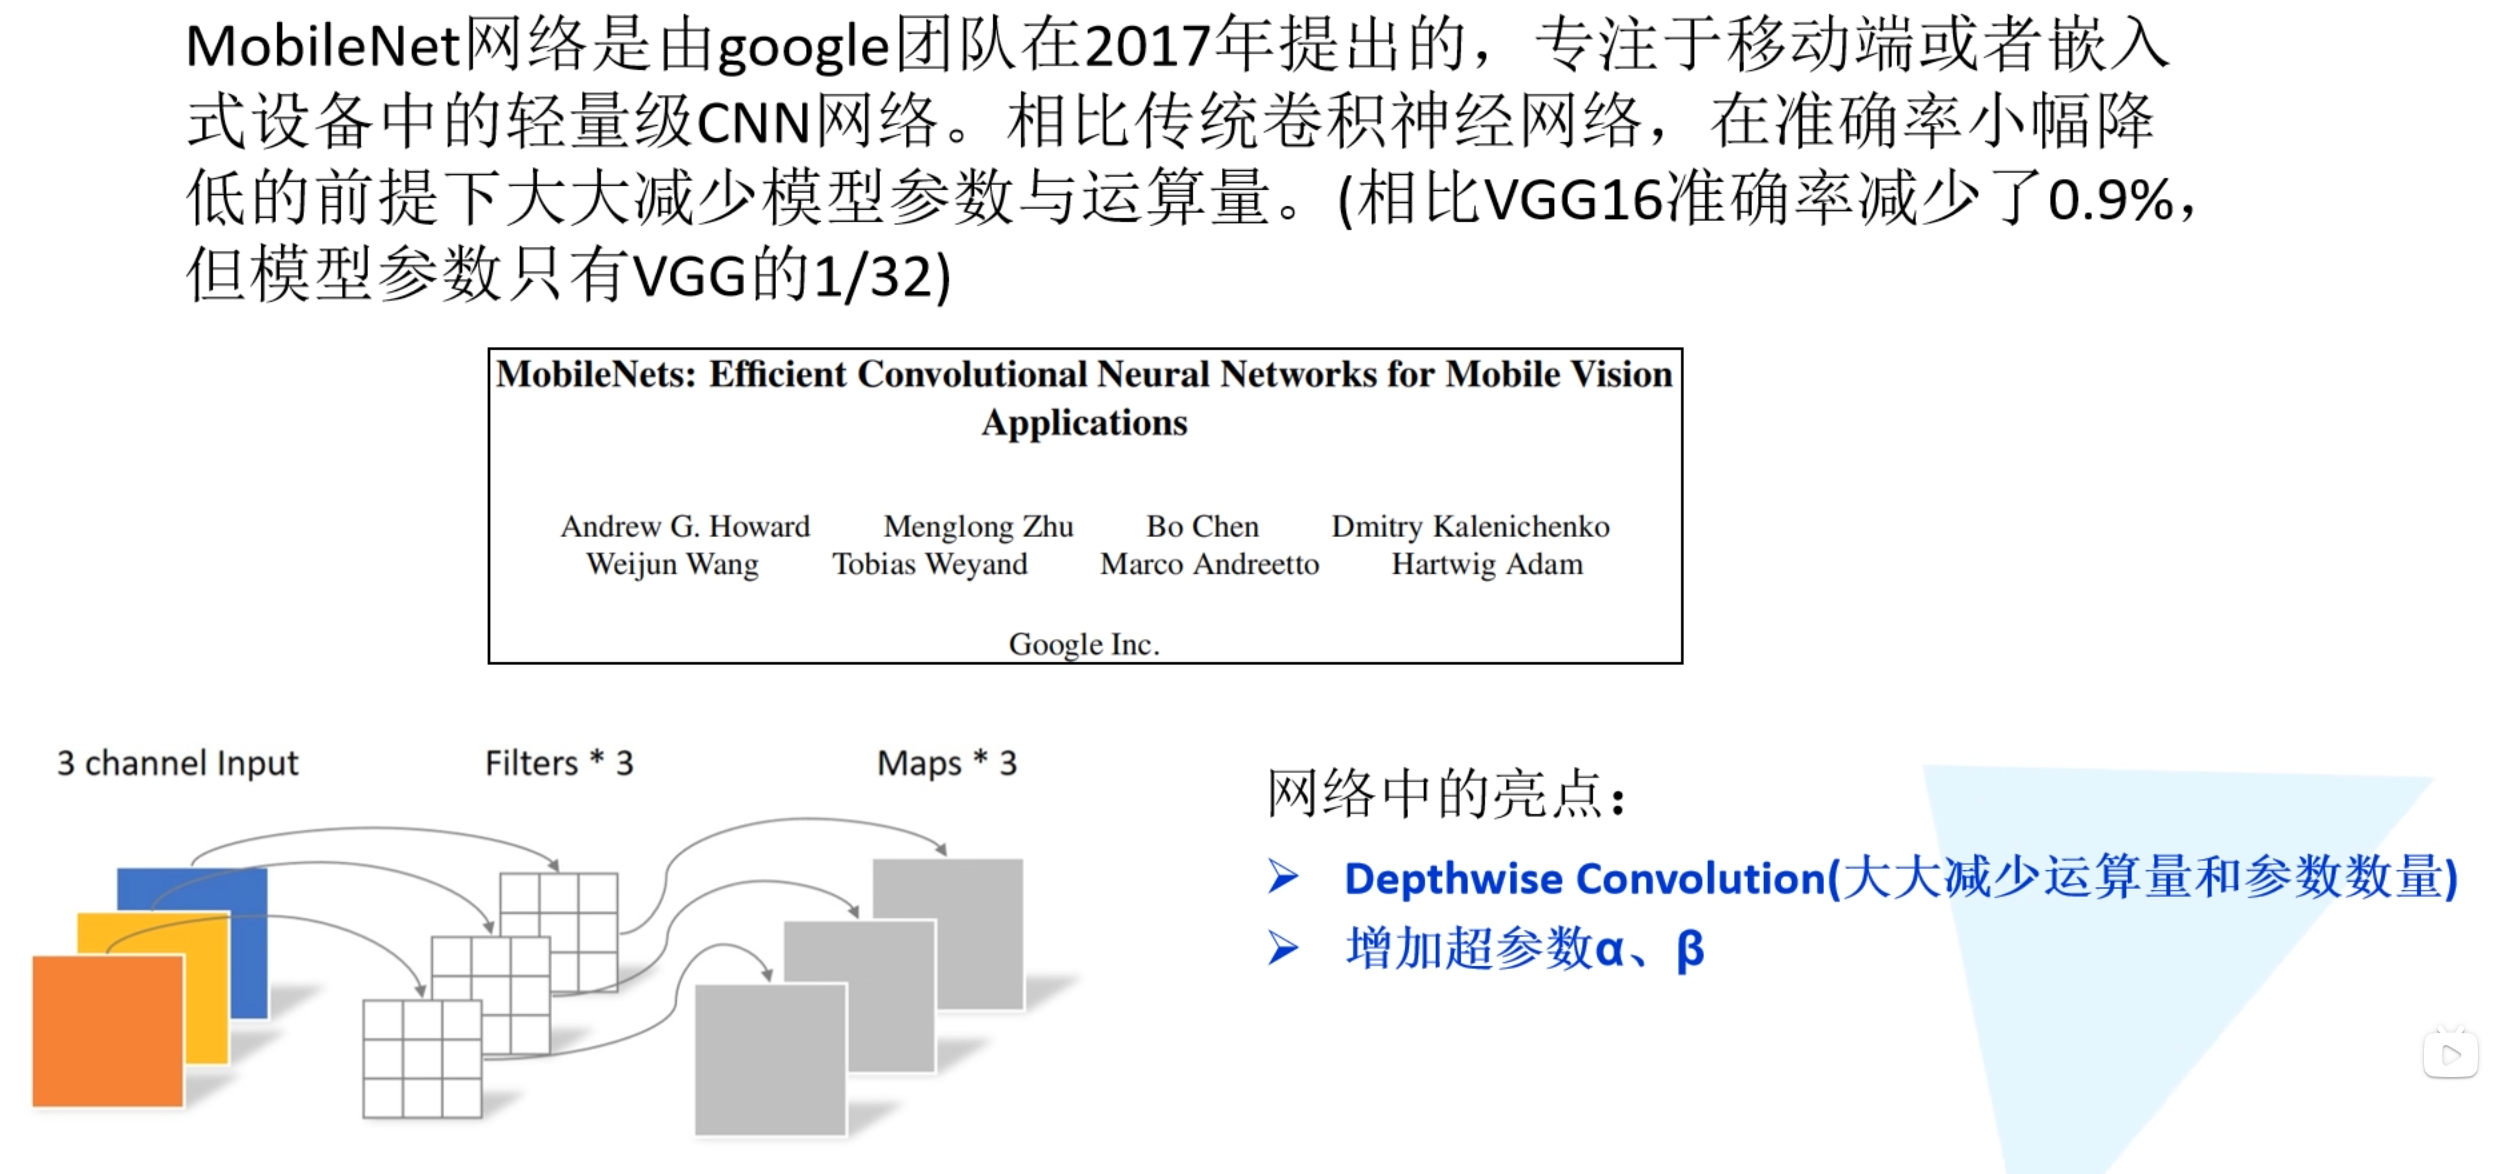

**大大减少模型参数数量**